In [1]:
import copy
import os
import pickle
import diagnostics
from datasets import *
from models import Resnet34, Resnet34FeatVis
from trainer import Trainer, Evaluator, set_seed
from trainer import CrossValidationUtils as cvu
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from metrics.confusion_matrix import *
from metrics.plot_functions import *
from trainer import Stacking
from validazione_pilota.inference import *

Python version: 3.8.2 (default, Mar 25 2020, 17:03:02) 
[GCC 7.3.0]
NumPy version: 1.18.1
scikit-learn version: 0.22.1
pandas version: 1.0.3
OpenCV version: 4.2.0
Torch version: 1.6.0
Available GPUs: 2
Cuda version: 10.2
Torch device: cuda


/home/alessandro/.conda/envs/defeatcovid19/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# select GPU
torch.cuda.set_device(1)

# create pickle input

In [3]:
# select DICOM list

folder_to_use = ['2020-09-24-acinesia-inferiore-3',
                 '2020-09-25-acinesia-validazione-ag',
                 '2020-09-30-eco-normali',
                 '2020-10-05-acinesia-validazione-ia-am']
pickle_folder = './validazione_pilota/PKL'

input_file = pd.read_csv('./validazione_pilota/s3sync.csv')
input_file.insert(0, 'folder', input_file.apply(lambda x: x['index'].replace('eco-scan-cardio/', '') \
                                            .replace(x['filename'], '').split('/')[0], axis=1))
input_file = input_file[input_file.folder.isin(folder_to_use)].reset_index(drop=True)
if input_file.filename.nunique() != len(input_file): print('\n\n ####### duplicated filename found')
print('\n\n')
print(input_file.folder.value_counts())




2020-09-30-eco-normali                   90
2020-10-05-acinesia-validazione-ia-am    64
2020-09-25-acinesia-validazione-ag       16
2020-09-24-acinesia-inferiore-3          13
Name: folder, dtype: int64


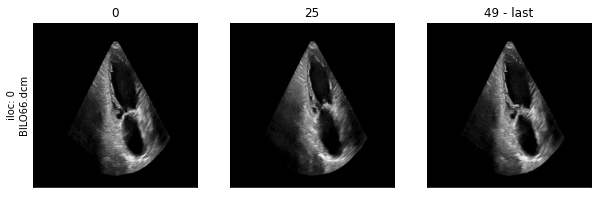

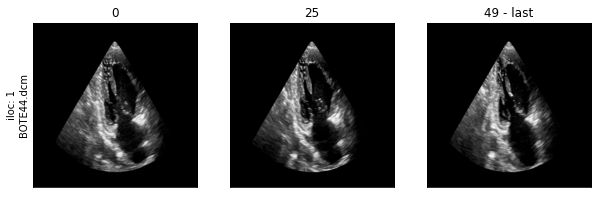


------------------ ERROR:  CAFE39.dcm
file has less than 50 frames


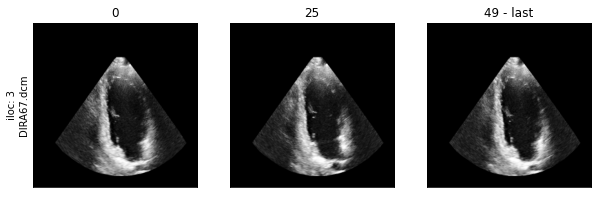

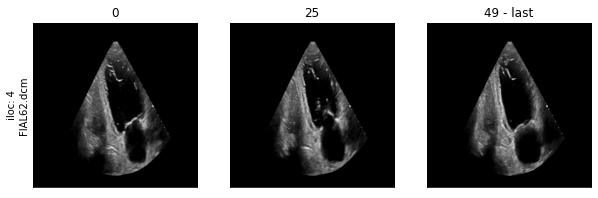

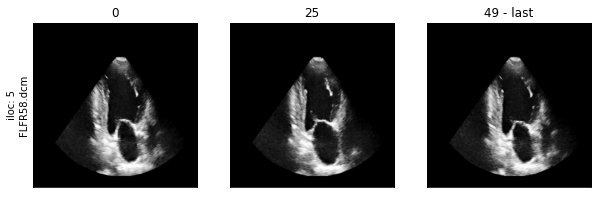

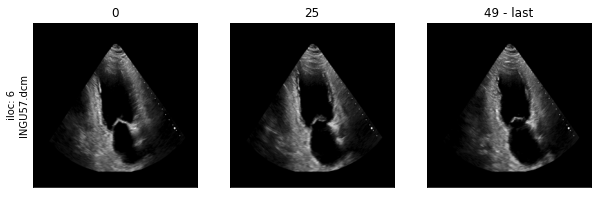


------------------ ERROR:  LIXI64.dcm
file has less than 50 frames

------------------ ERROR:  PAAL34.dcm
file has less than 50 frames


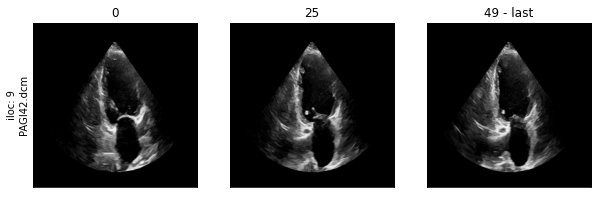

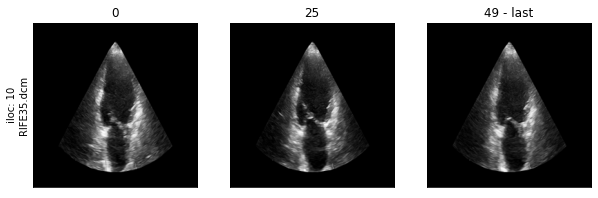

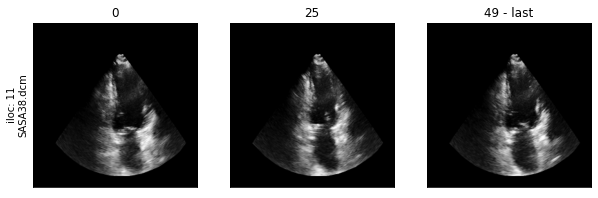

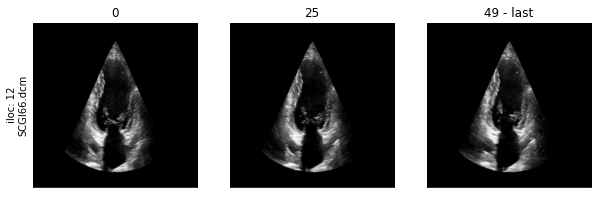

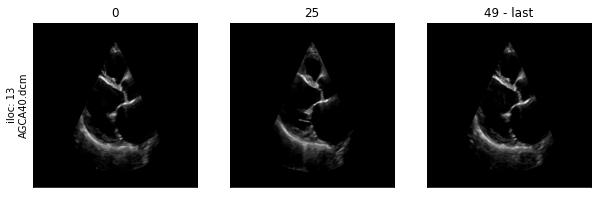

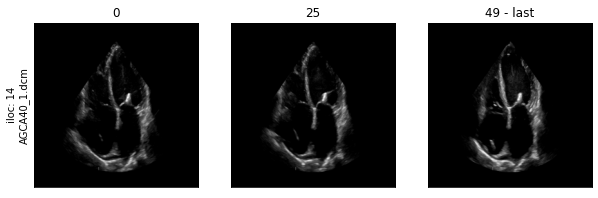

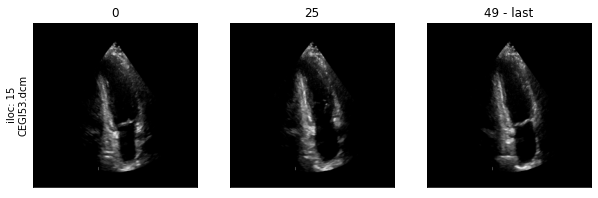

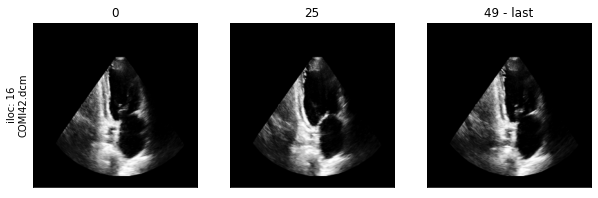

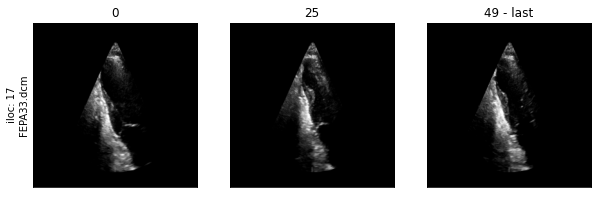

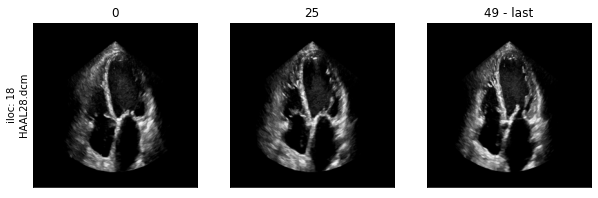

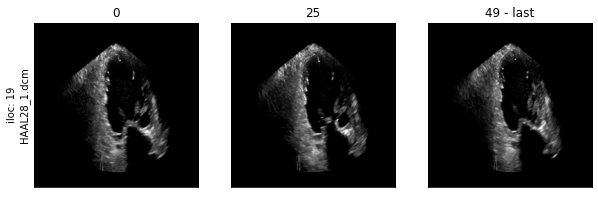

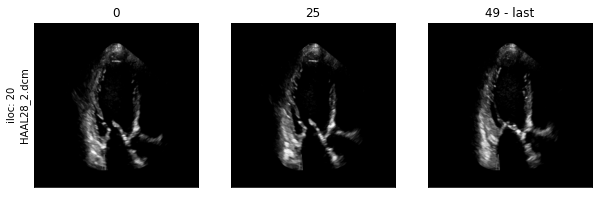

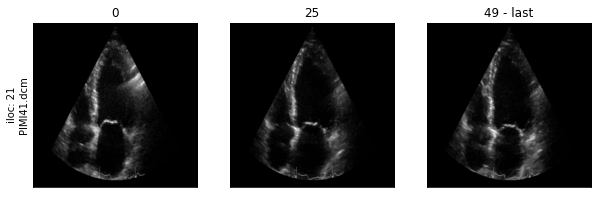

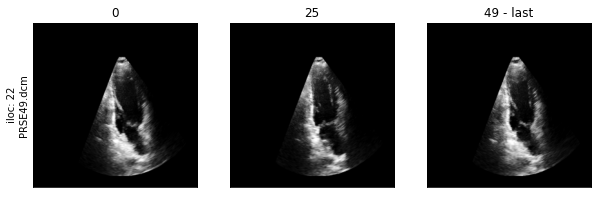

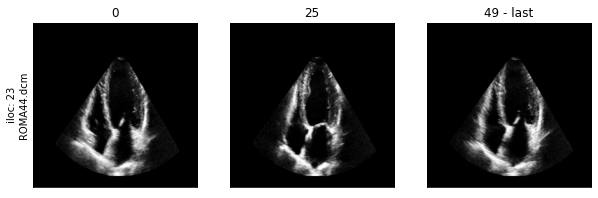

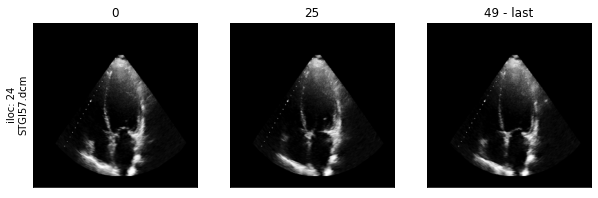

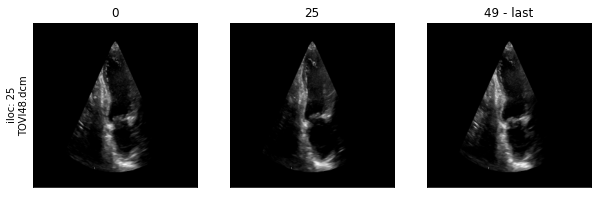

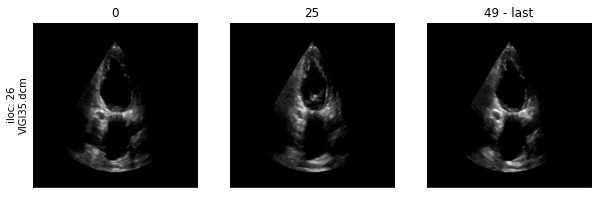

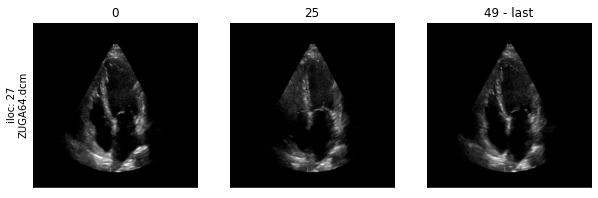

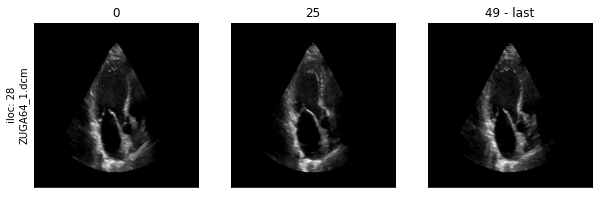


------------------ ERROR:  2Cbece41.dcm
file has less than 50 frames


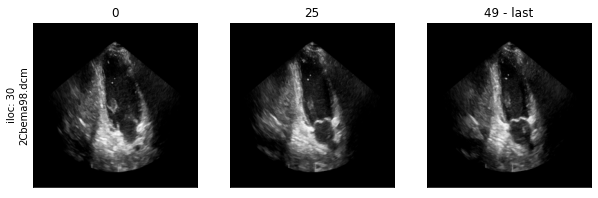

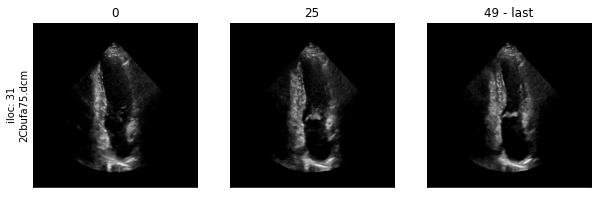

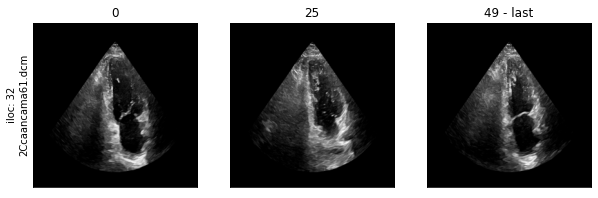


------------------ ERROR:  2Ccalaanvi65.dcm
file has less than 50 frames


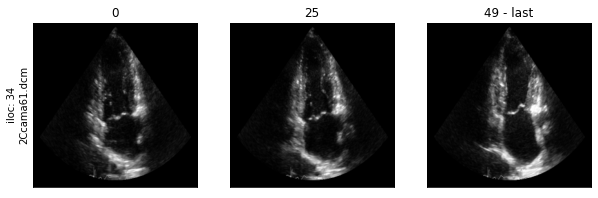

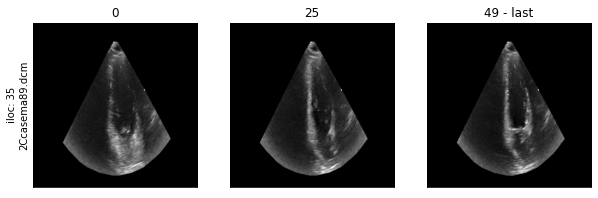


------------------ ERROR:  2Cdefamaan90.dcm
file has less than 50 frames


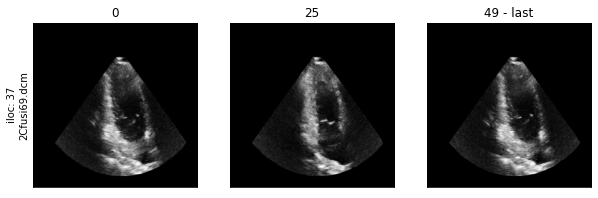

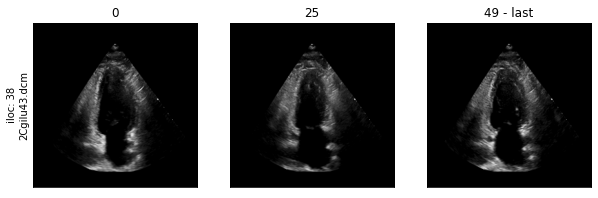

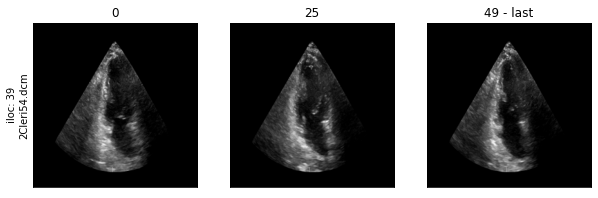

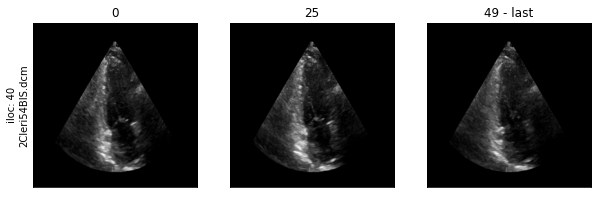


------------------ ERROR:  2Clian52.dcm
file has less than 50 frames


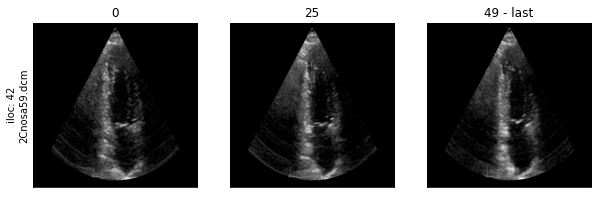

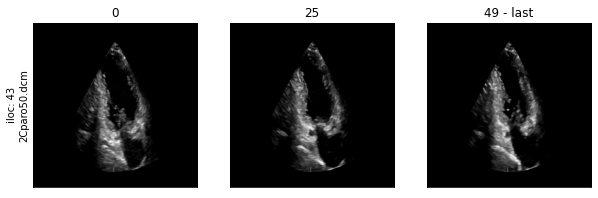

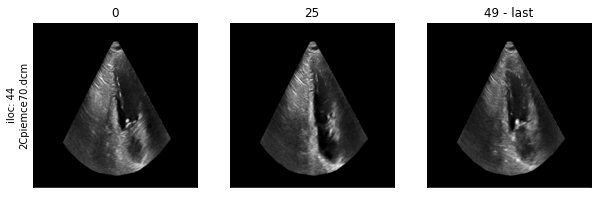

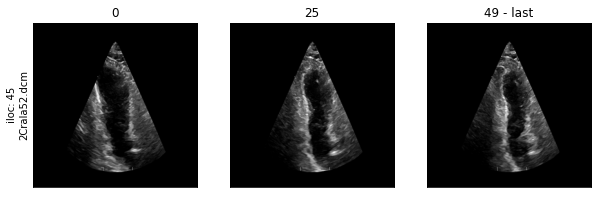

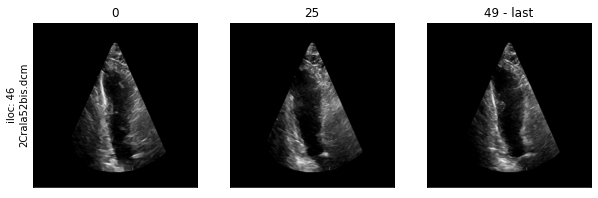

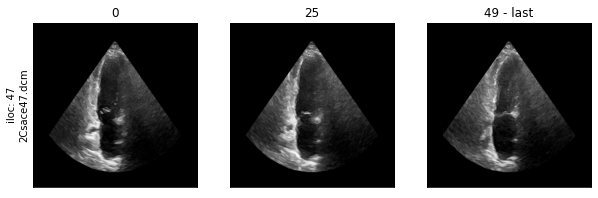

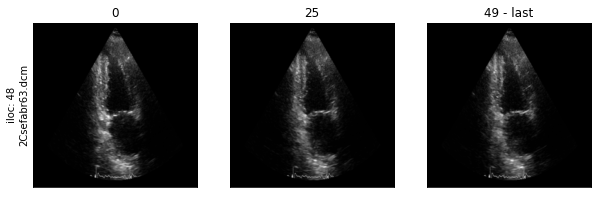

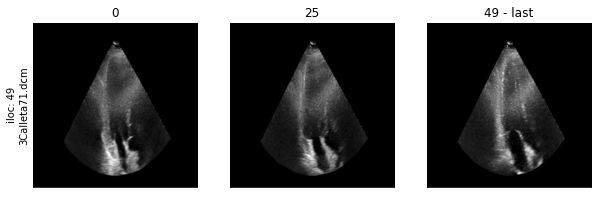


------------------ ERROR:  3Cbece41.dcm
file has less than 50 frames


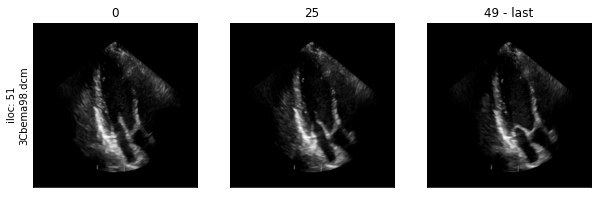

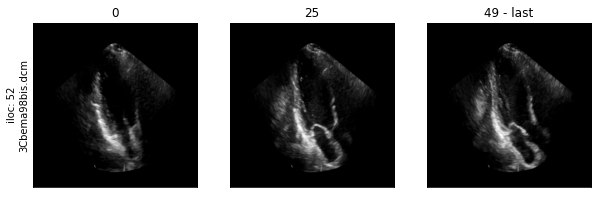

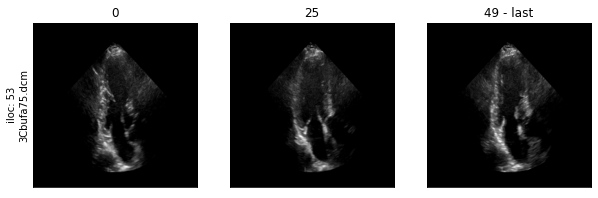

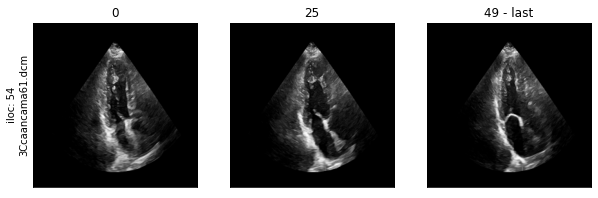


------------------ ERROR:  3Ccalaanvi65.dcm
file has less than 50 frames


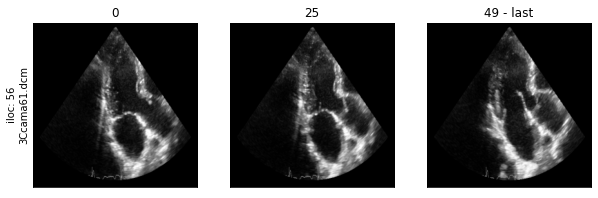


------------------ ERROR:  3Cdefamaan90.dcm
file has less than 50 frames


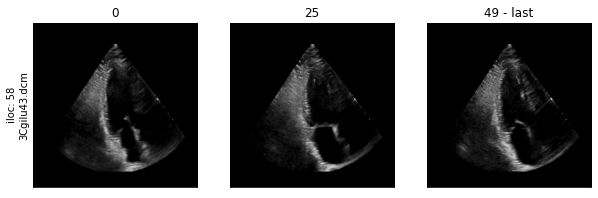

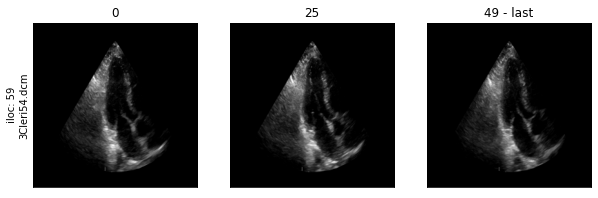


------------------ ERROR:  3Clian52.dcm
file has less than 50 frames


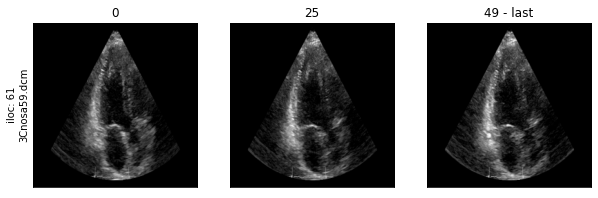

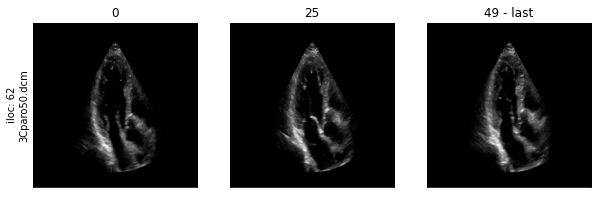

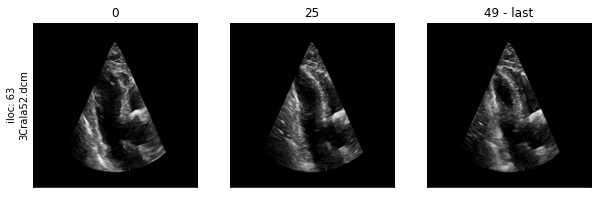

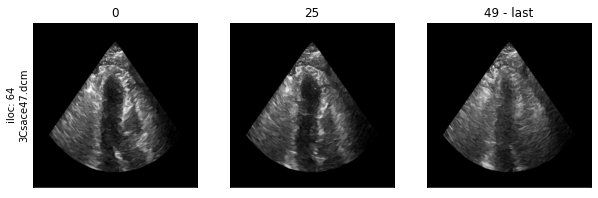

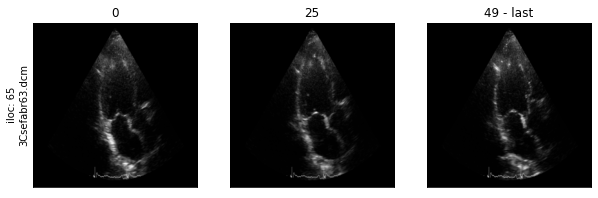

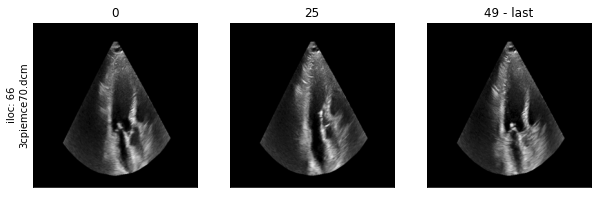

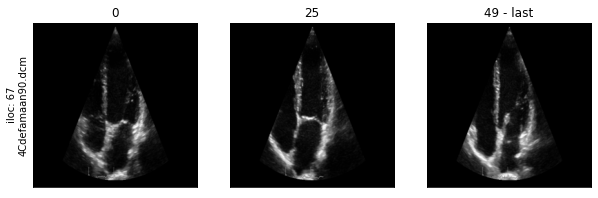

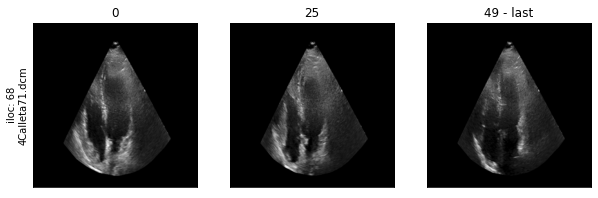

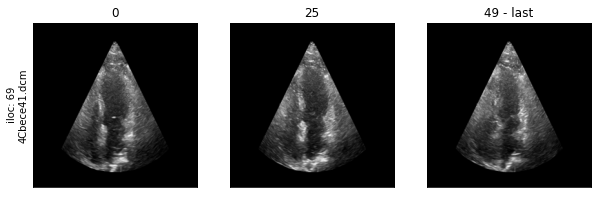

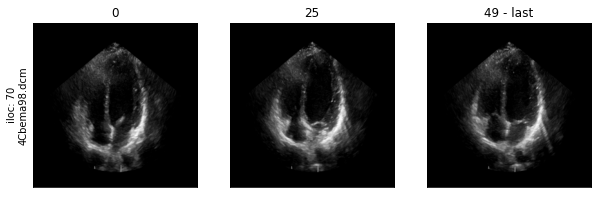

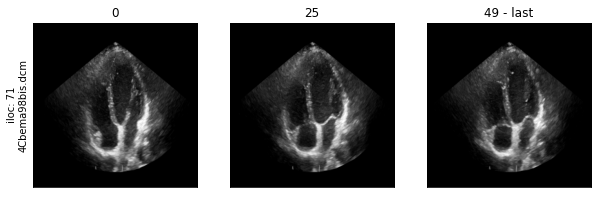

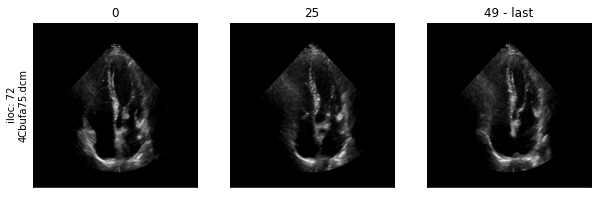

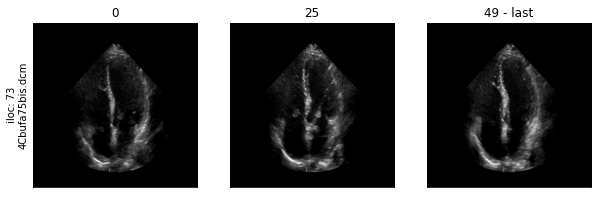

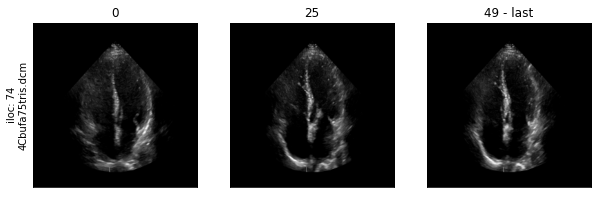

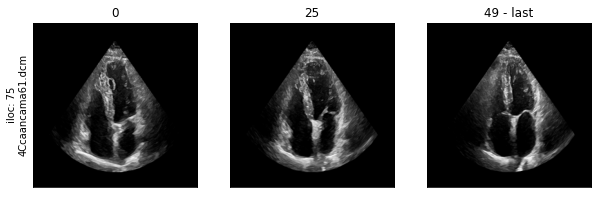

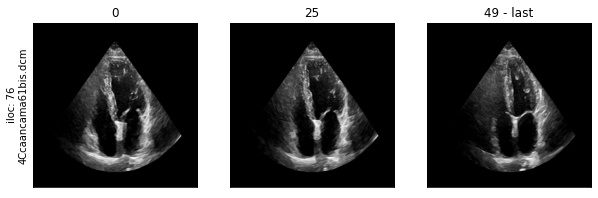


------------------ ERROR:  4Ccalaanvi65.dcm
file has less than 50 frames

------------------ ERROR:  4Ccalaanvi65bis.dcm
file has less than 50 frames


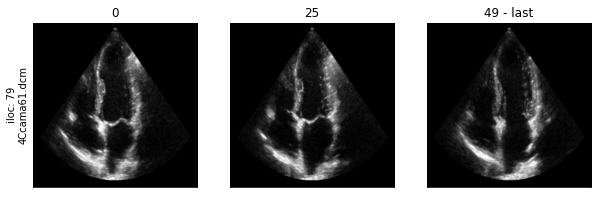

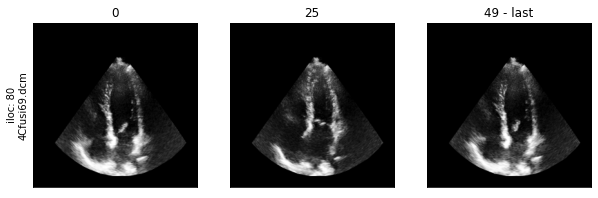

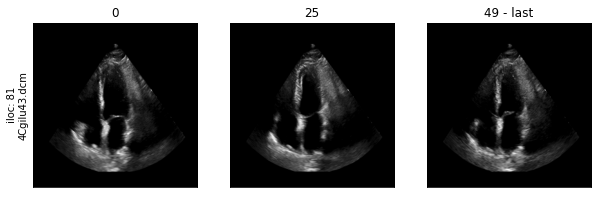

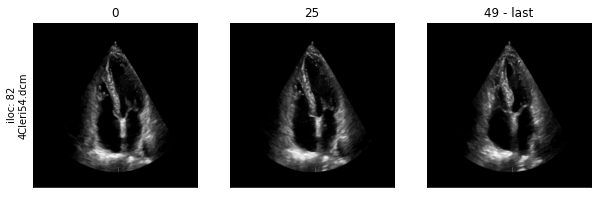


------------------ ERROR:  4Clian52.dcm
file has less than 50 frames

------------------ ERROR:  4Clian52bis.dcm
file has less than 50 frames


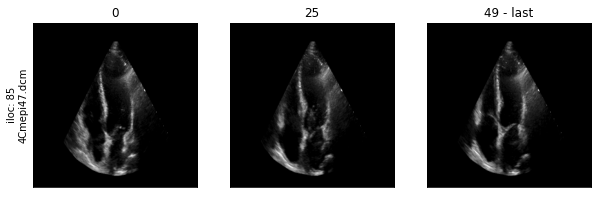

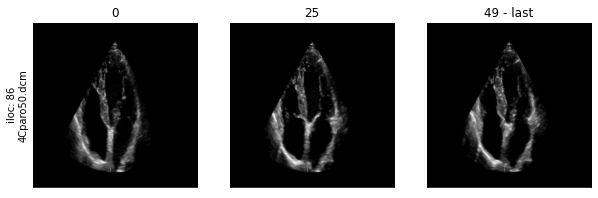

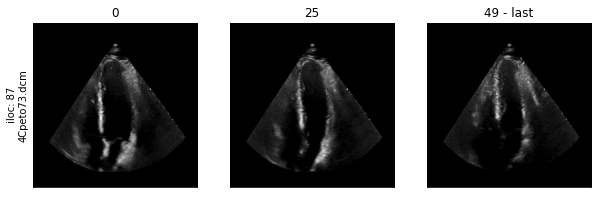

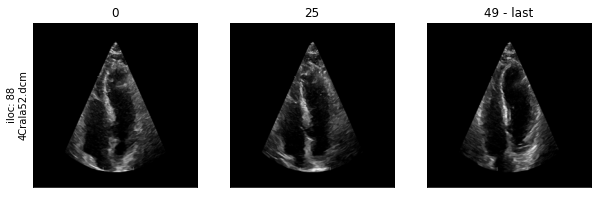

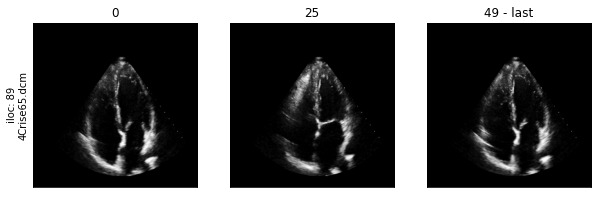

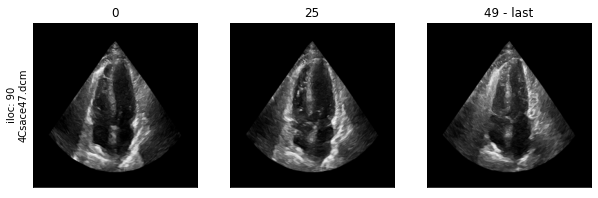

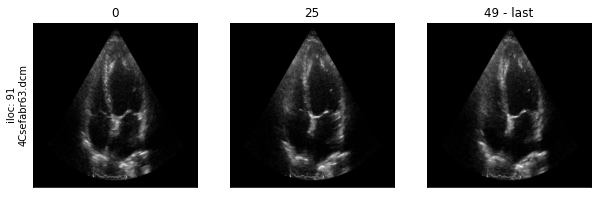

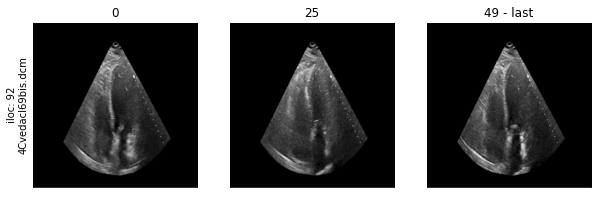

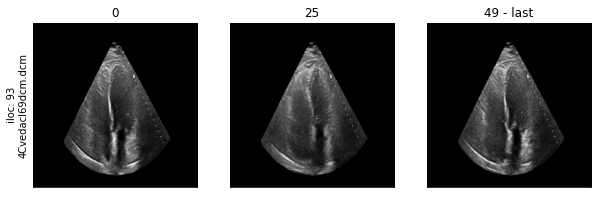

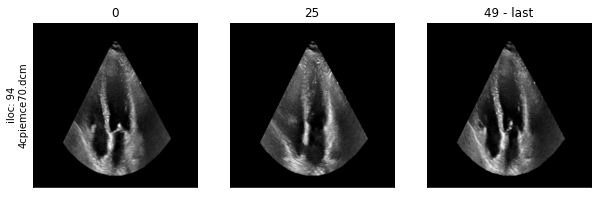

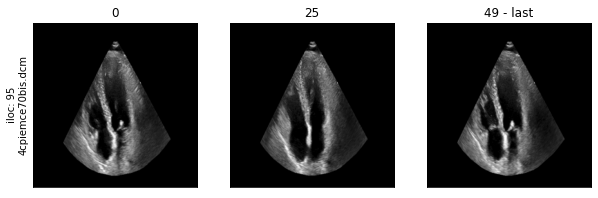

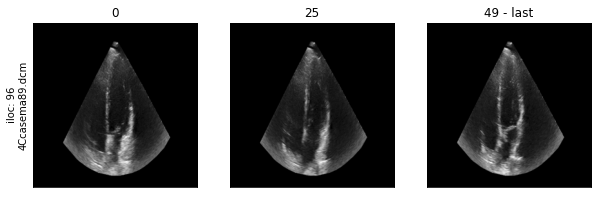

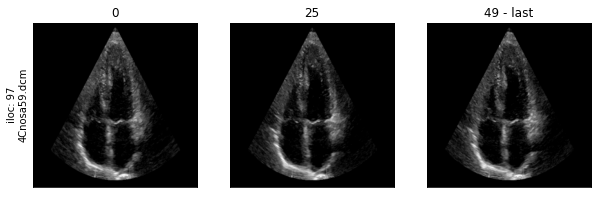

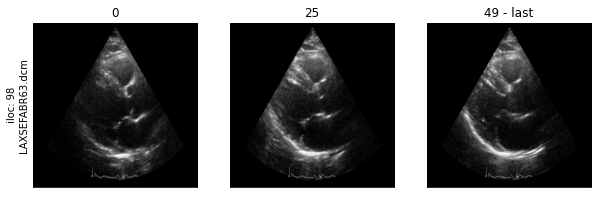

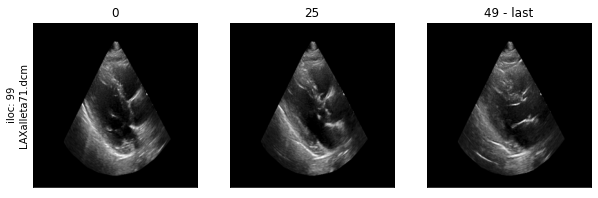

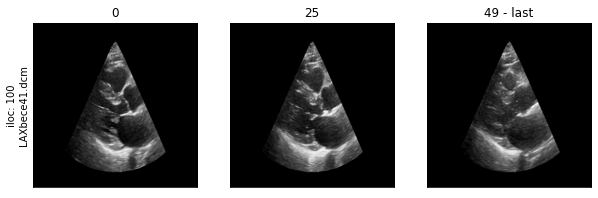

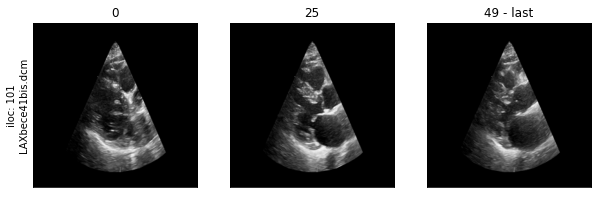

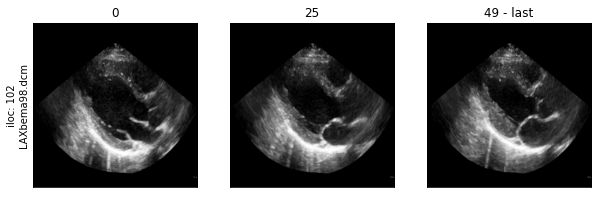

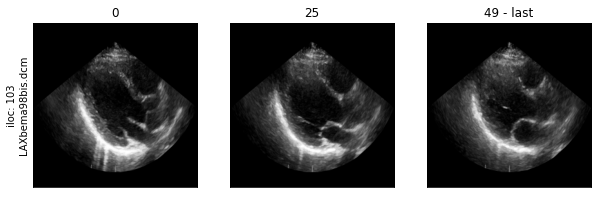

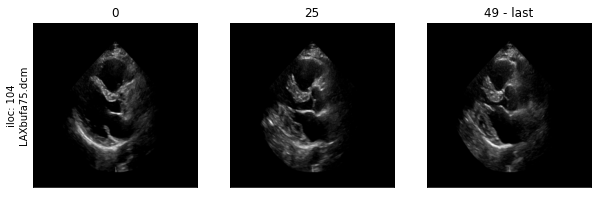

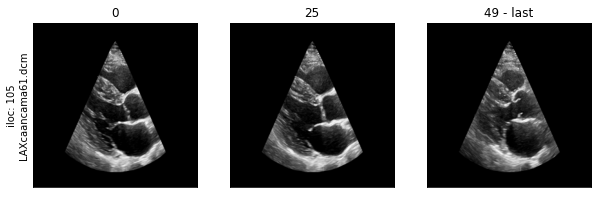


------------------ ERROR:  LAXcalaanvi65.dcm
file has less than 50 frames


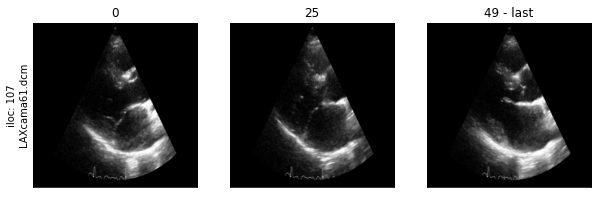

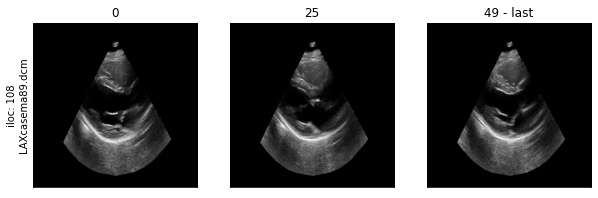

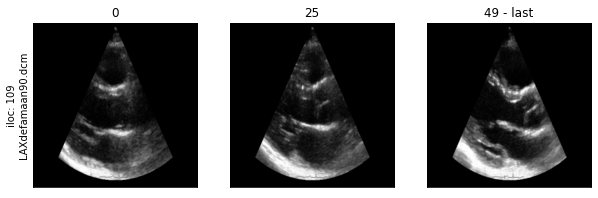

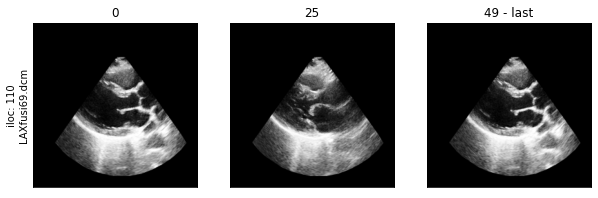

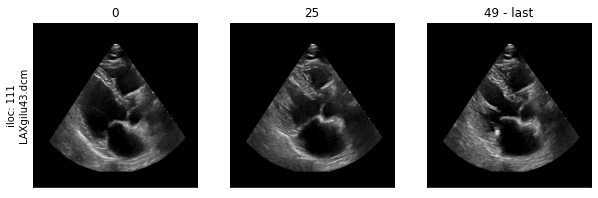

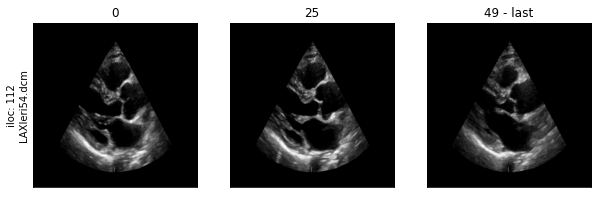


------------------ ERROR:  LAXlian52.dcm
file has less than 50 frames


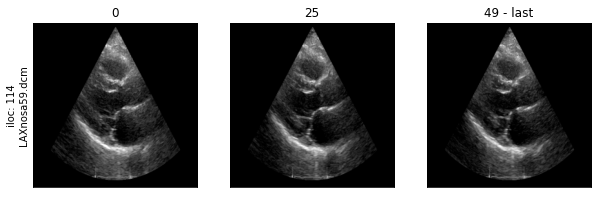

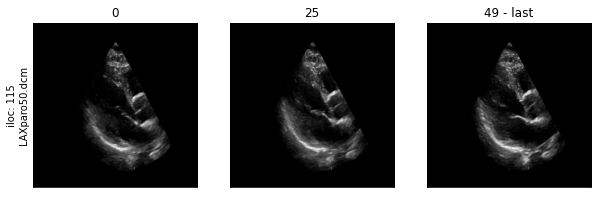

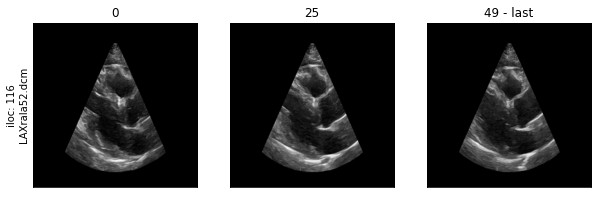

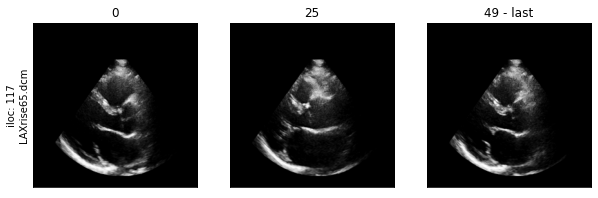

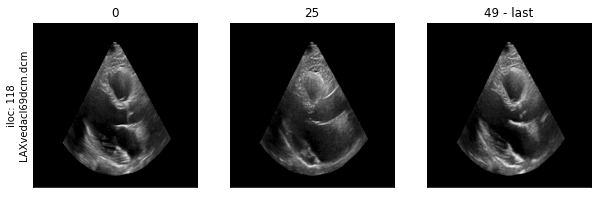

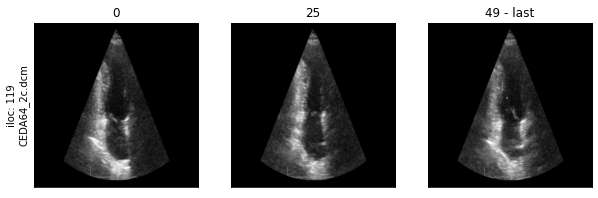


------------------ ERROR:  COGI70_2C.dcm
file has less than 50 frames

------------------ ERROR:  COGI70_2Cbis.dcm
file has less than 50 frames


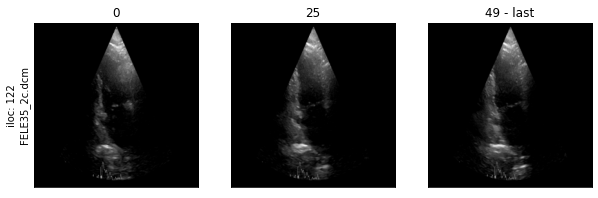

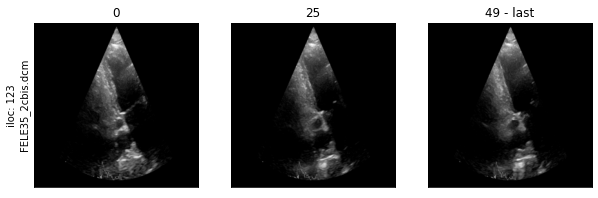

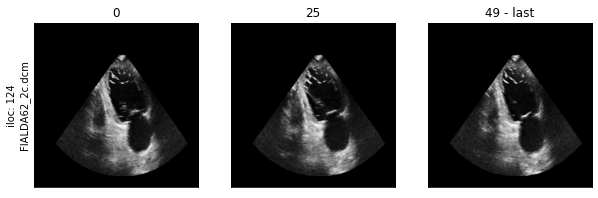

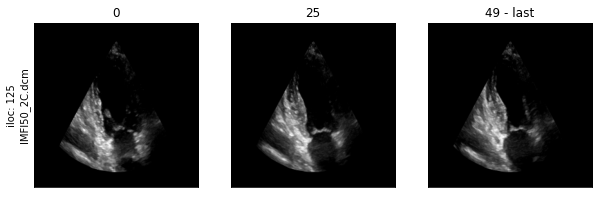

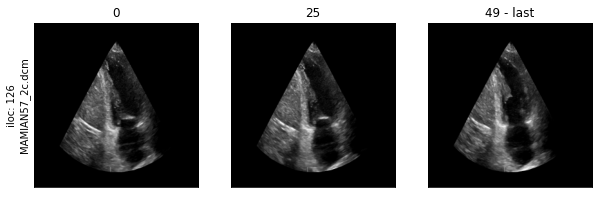

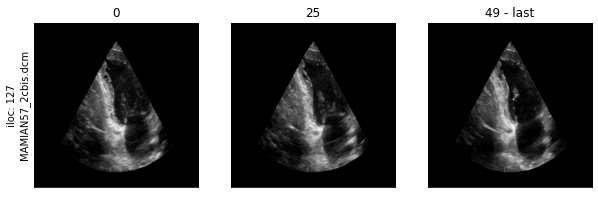

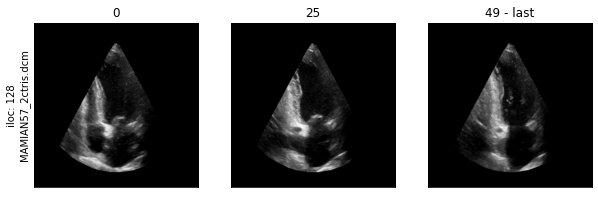

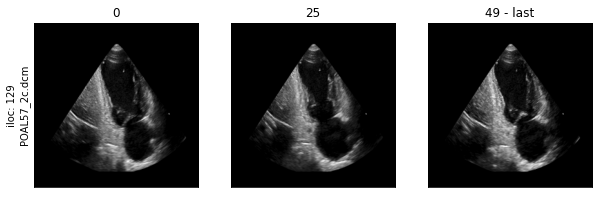

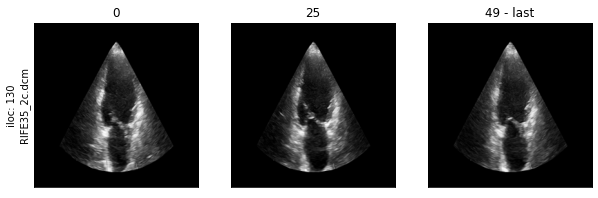

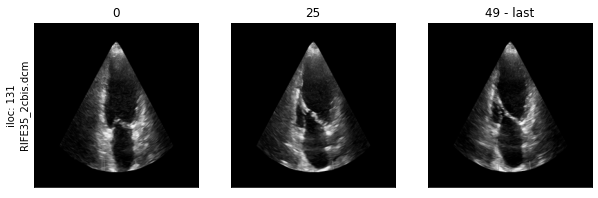

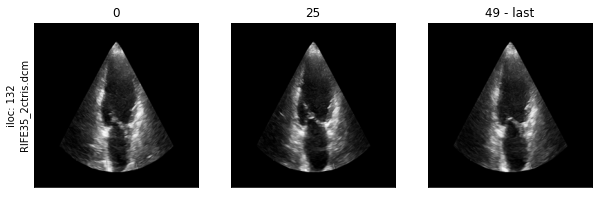

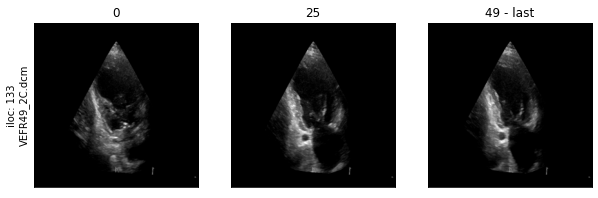

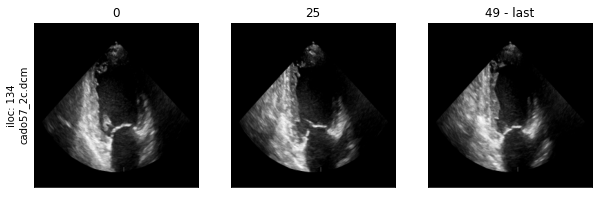


------------------ ERROR:  jara68_2c.dcm
file has less than 50 frames

------------------ ERROR:  jara68_2cbis.dcm
file has less than 50 frames


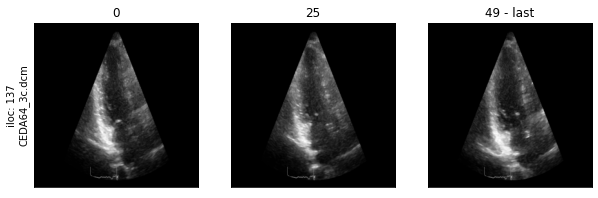


------------------ ERROR:  COGI70_3C.dcm
file has less than 50 frames

------------------ ERROR:  FELE35_3c.dcm
file has less than 50 frames


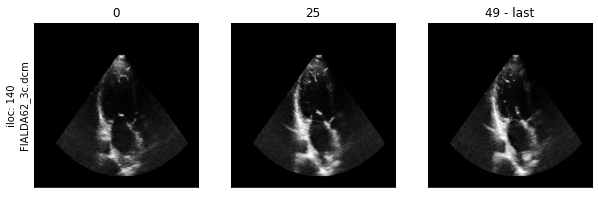

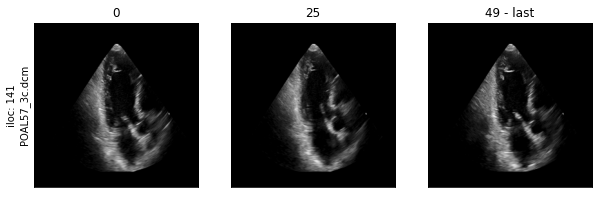

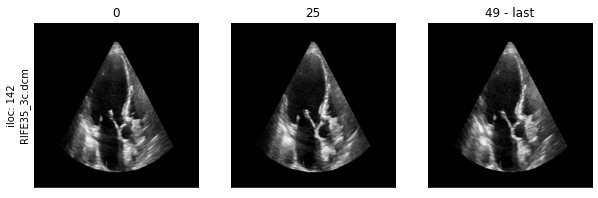

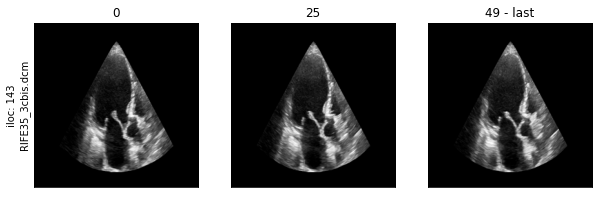

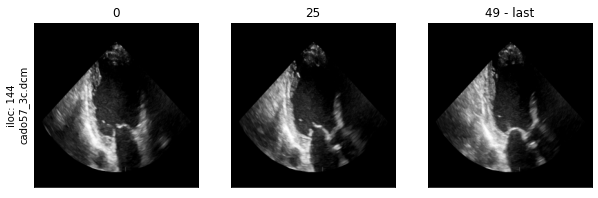

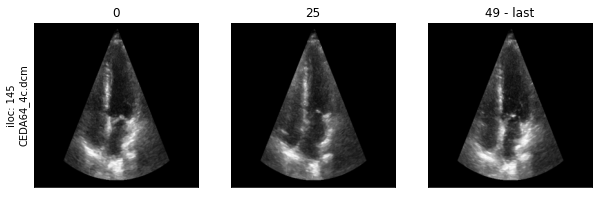


------------------ ERROR:  COGI70_4C.dcm
file has less than 50 frames

------------------ ERROR:  COGI70_4Cbis.dcm
file has less than 50 frames

------------------ ERROR:  FELE35_4c.dcm
file has less than 50 frames

------------------ ERROR:  FELE35_4cbis.dcm
file has less than 50 frames


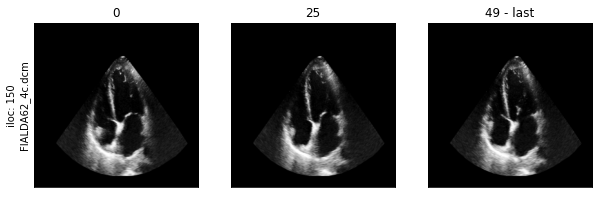

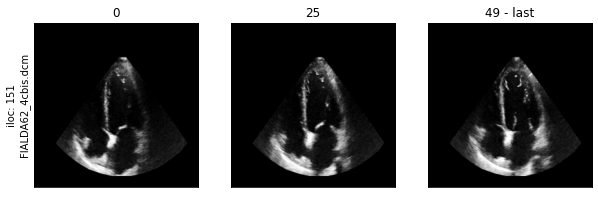

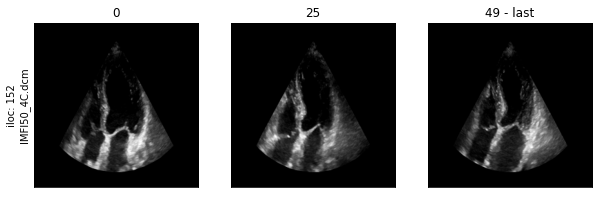

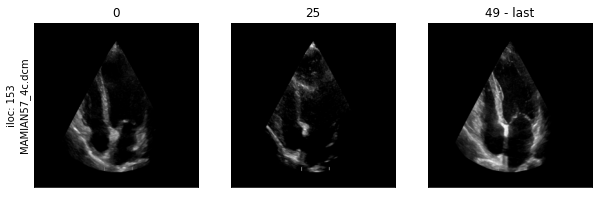

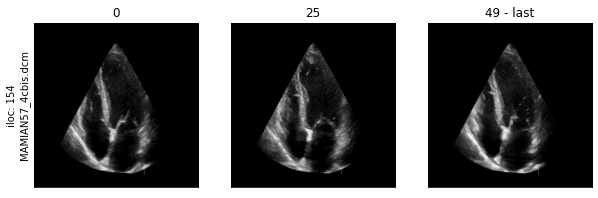

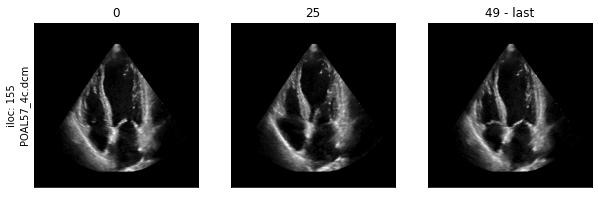

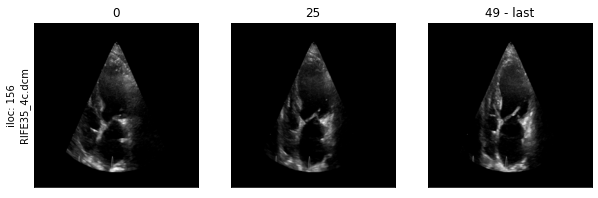

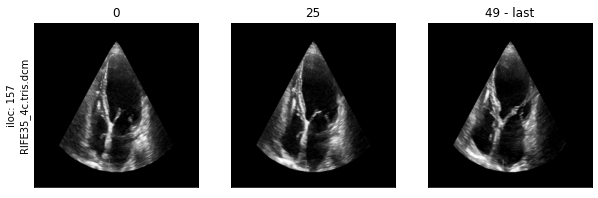

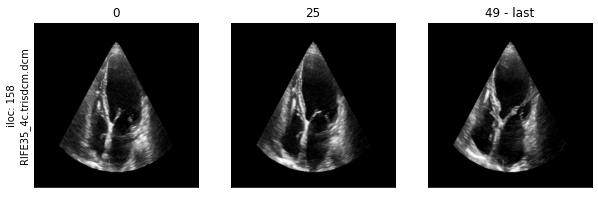

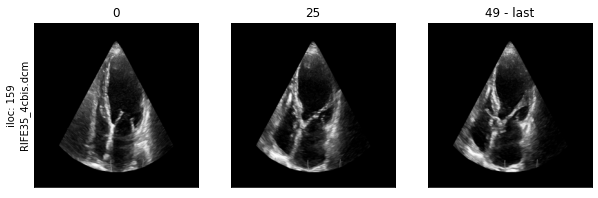

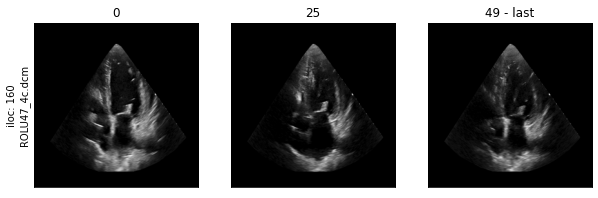

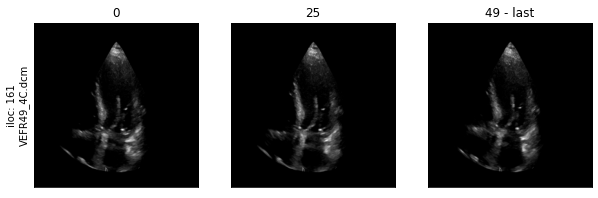

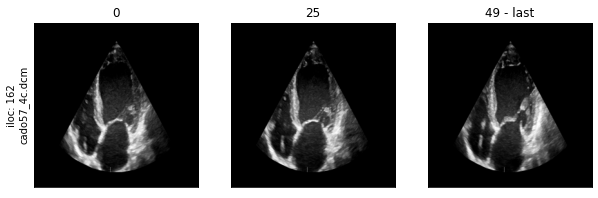


------------------ ERROR:  jara68_4c.dcm
file has less than 50 frames


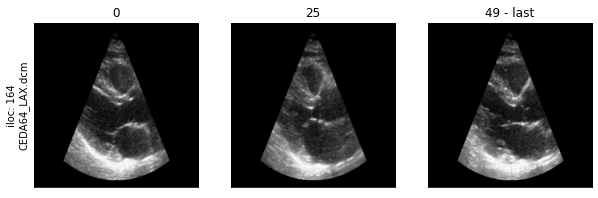


------------------ ERROR:  COGI70_LAX.dcm
file has less than 50 frames


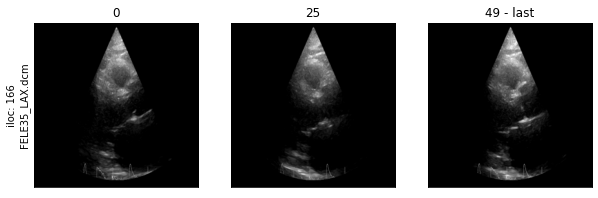

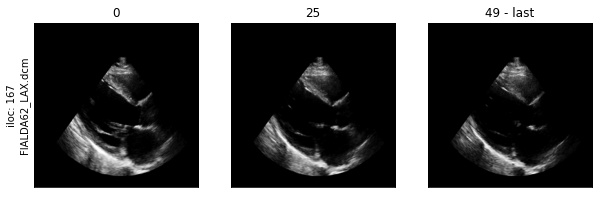

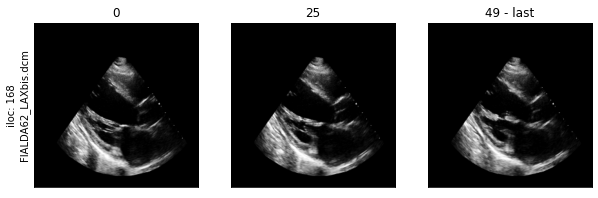

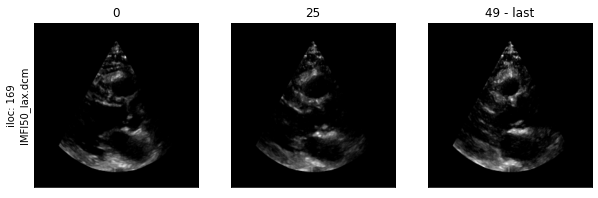

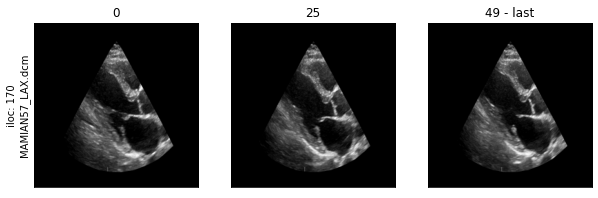

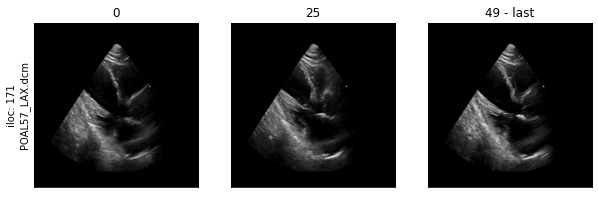

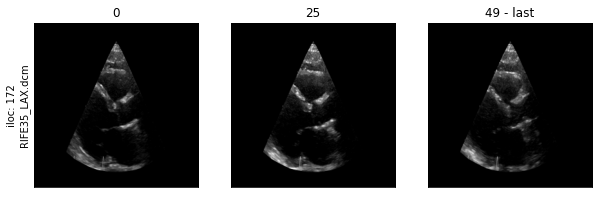

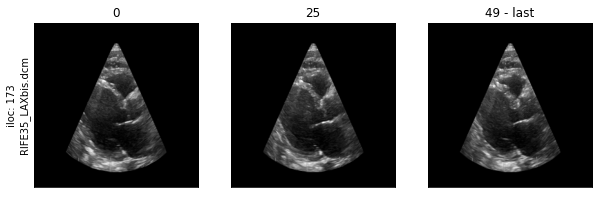

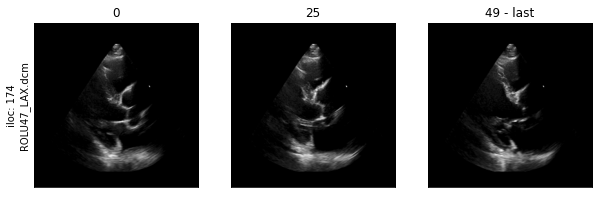

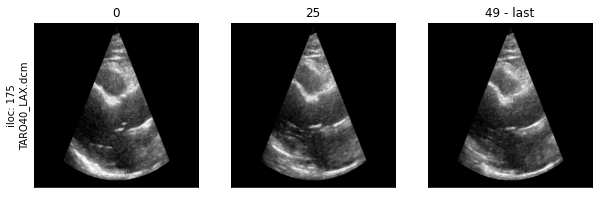

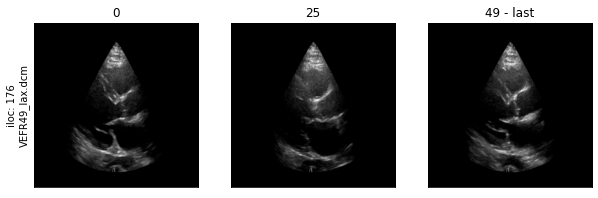


------------------ ERROR:  cado57_lax.dcm
file has less than 50 frames

------------------ ERROR:  jara68_lax.dcm
file has less than 50 frames


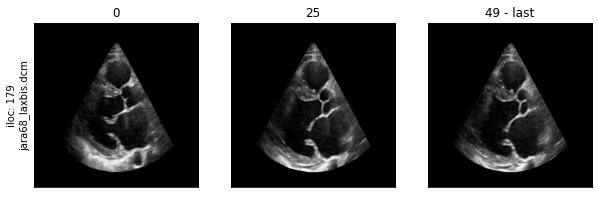

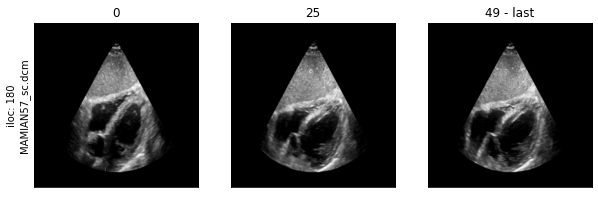

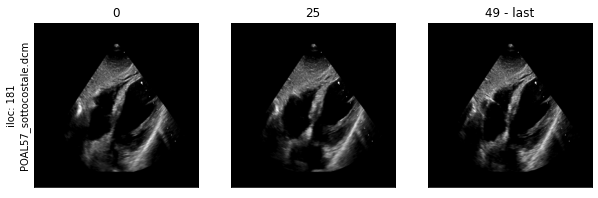

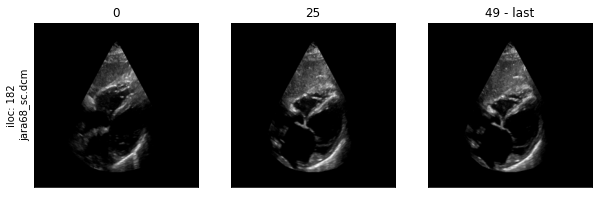

In [71]:
# convert DICOM to numpy and save as .pickle

failed_list = {}
for ind, row in input_file.iterrows():
    path = row.local_path
    bitearray = open(path, "rb").read()
    try:
        image_array = input_fn(bitearray, 'application/dicom').numpy()
        fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=False, sharex=False)
        ax = ax.flatten()
        tot_frames = image_array.shape[0]
        ax_c=0
        for frame in [0, round(tot_frames / 2), tot_frames-1]:
            ax[ax_c].imshow(image_array[frame], cmap='gray')
            ax[ax_c].set_xticks([])
            ax[ax_c].set_yticks([])
            if frame == 0:
                ax[ax_c].set_title(frame)
            elif frame == tot_frames-1:
                ax[ax_c].set_title(str(frame)+' - last')
            else:
                ax[ax_c].set_title(frame)
            if ax_c % 3 == 0:
                ax[ax_c].set_ylabel('iloc: '+str(ind)+'\n'+row.filename, color='black')
            ax_c += 1
        plt.show()
        img_255 = (image_array * 255).astype(np.uint8)
        # save pickle
        with open(os.path.join(pickle_folder, row.filename.replace('.dcm', '.pickle')), 'wb') as handle:
                 pickle.dump(img_255, handle, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        failed_list[row.filename]={'ind': ind, 'error': e}
        print('\n------------------ ERROR: ', row.filename)
        print(e)

In [128]:
print('\n--------Total failed DICOM:', len(failed_list), '\n\n')
for k, v in failed_list.items():
    print(k, v['error'])
    
remove_index = [v['ind'] for v in failed_list.values()]
final_input = input_file[~input_file.index.isin(remove_index)]
final_input['pickle'] = final_input.apply(lambda x: os.path.join(pickle_folder, x['filename'].replace('.dcm', '.pickle')), axis=1)
final_input = final_input.reset_index(drop=True)
if len(final_input) != (len(input_file) - len(remove_index)): print('\n ###### error in removing failed DICOM')
print('\n--------Total remaining:', len(final_input))
final_input.to_csv('./validazione_pilota/final_input.csv', index=False)


--------Total failed DICOM: 31 


CAFE39.dcm file has less than 50 frames
LIXI64.dcm file has less than 50 frames
PAAL34.dcm file has less than 50 frames
2Cbece41.dcm file has less than 50 frames
2Ccalaanvi65.dcm file has less than 50 frames
2Cdefamaan90.dcm file has less than 50 frames
2Clian52.dcm file has less than 50 frames
3Cbece41.dcm file has less than 50 frames
3Ccalaanvi65.dcm file has less than 50 frames
3Cdefamaan90.dcm file has less than 50 frames
3Clian52.dcm file has less than 50 frames
4Ccalaanvi65.dcm file has less than 50 frames
4Ccalaanvi65bis.dcm file has less than 50 frames
4Clian52.dcm file has less than 50 frames
4Clian52bis.dcm file has less than 50 frames
LAXcalaanvi65.dcm file has less than 50 frames
LAXlian52.dcm file has less than 50 frames
COGI70_2C.dcm file has less than 50 frames
COGI70_2Cbis.dcm file has less than 50 frames
jara68_2c.dcm file has less than 50 frames
jara68_2cbis.dcm file has less than 50 frames
COGI70_3C.dcm file has less than 50 frames


<ipython-input-128-ae27e621e153>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_input['pickle'] = final_input.apply(lambda x: os.path.join(pickle_folder, x['filename'].replace('.dcm', '.pickle')), axis=1)


# Predict

In [4]:
final_input = pd.read_csv('./validazione_pilota/final_input.csv')

## predict with Stacking


 --- Evaluating input models predictions ... Done in 0:00:41

 --- Evaluating stacked learner predictions ... Done in 0:00:00


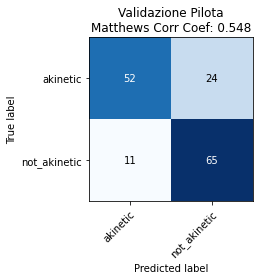

              precision    recall  f1-score   support

    akinetic       0.83      0.68      0.75        76
not_akinetic       0.73      0.86      0.79        76

    accuracy                           0.77       152
   macro avg       0.78      0.77      0.77       152
weighted avg       0.78      0.77      0.77       152



In [5]:
model_ID_to_stack = ['AkineticNoDiff_Resnet34_BCE', 'AkineticNoDiff_Resnet34_BCE_inv_class',
                     'AkineticNoDiff_Resnet34_FocLos', 'AkineticNoDiff_Resnet34_FocLos_inv_class']
model_ID = 'validazione_pilota'
new_prediction_path = list(final_input.pickle)
stacked_learner = 'GBM'




input_name = 'eco_50_first_Nodiff_samplFirst_mask_256'
size = 256
dataset = ecoSaccoDataset(input_name, target_class='akinetic', size=size, show_info=False)
stacking = Stacking(dataset = dataset, model_ID_to_stack = model_ID_to_stack, model_ID = model_ID, plot_distribution=False)
out = stacking.predict(new_prediction_path = new_prediction_path,
                       stacked_learner = stacked_learner,
                       stacked_learner_path = 'checkpoints/AkineticNoDiff_Stacking_final_'+stacked_learner+'.pickle',
                       input_split_averaging = 'average',
                       final_output_averaging = 'average')

final_prediction = out['prediction']
final_prediction = final_prediction.merge(final_input[['pickle', 'akinetic']], left_on='image', right_on='pickle')[['pickle', 'pred_label', 'akinetic']]
final_prediction.akinetic = final_prediction.akinetic.astype(type(final_prediction.pred_label[0]))
final_prediction = final_prediction.rename(columns={'pred_label': 'pred', 'akinetic': 'true'})

_, _, _, _, _ = plot_confusion_matrix(final_prediction.true, final_prediction.pred, original_dataset = dataset.df, title='Validazione Pilota')

## predict with Single Model

In [13]:
pred_dataset = copy.deepcopy(dataset)
pred_dataset.df = pd.DataFrame({'image': list(final_input.pickle),
                                'label': final_input.akinetic.astype(type(dataset.df.label[0]))})\
                    .merge(dataset.df[['label', 'meaning']].drop_duplicates(), left_on = 'label', right_on = 'label')

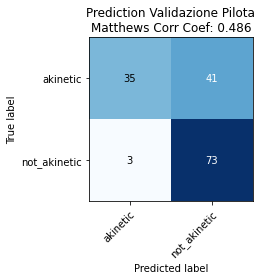

precision recall f1-score support
akinetic          0.92   0.46     0.61      76
not_akinetic      0.64   0.96     0.77      76
accuracy                          0.71     152
macro avg         0.78   0.71     0.69     152
weighted avg      0.78   0.71     0.69     152

In [14]:
model_ID='AkineticNoDiff_Resnet34_BCE_full'

out=cvu.predict_dataset(model_ID=model_ID,
                      dataset=pred_dataset,
                      new_index=np.array(pred_dataset.df.index),
                      batch_size=10,
                      add_title='Validazione Pilota')

In [49]:
validation_results = out['prediction'].sort_index()
validation_results = validation_results.merge(pred_dataset.df['image'], left_index = True, right_index = True)
validation_results.insert(0, 'file', validation_results.apply(lambda x: os.path.basename(x['image']).replace('pickle', 'dcm'), axis = 1))
validation_results['true'] = validation_results['true'].astype(int)
validation_results['pred_class'] = validation_results['pred_class'].astype(int)
validation_results = validation_results.drop(columns = ['image', 'pred', 'pred_perc'])
validation_results.to_csv('./validazione_pilota/single_model_prediction.csv')

/home/alessandro/.conda/envs/defeatcovid19/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


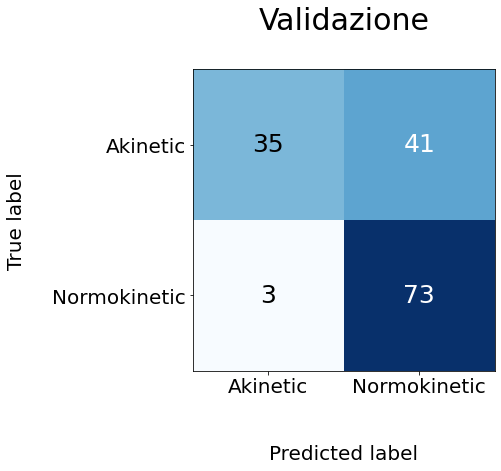

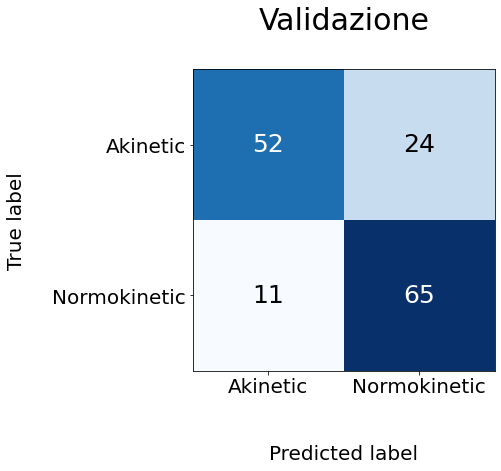

In [11]:
## confusion matrix for paper

save_path = 'conf_mat_Resnet.png'
cc = {'Validazione_1': {'conf_mat': np.array([[35,41], [3,73]]),
                'add_conf_elements': None},
      'Validazione_2': {'conf_mat': np.array([[52,24], [11,65]]),
                'add_conf_elements': None}
     }


target_names = ['Akinetic', 'Normokinetic']
normalize=False
cmap=plt.cm.Blues

fig_path = []
for k, v in cc.items():

    conf_mat = v['conf_mat']
    add_conf_elements = v['add_conf_elements']
    title=k[:-2]+'\n'

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    #     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]))
    ax.set_ylabel('True label\n', size = 20)
    ax.set_xlabel('\n\nPredicted label', size = 20)
    ax.set_xticklabels(target_names, size = 20)
    ax.set_yticklabels(target_names, size = 20)
    ax.set_title(title, size = 30)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            if add_conf_elements is None:
                ax.text(j, i, format(conf_mat[i, j], fmt),
                        ha="center", va="center",
                        color="white" if conf_mat[i, j] > thresh else "black", size = 25)
            else:
                ax.text(j, i, str(format(conf_mat[i, j], fmt)) + str(add_conf_elements[i, j]),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black", size = 25)

    fig.tight_layout()
    fig.savefig(k+'.png')

# get_concat_h([Image.open(f) for f in fig_path], offset=80).save(save_path)
# _=[os.remove(f) for f in fig_path]